In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from currency_converter import CurrencyConverter
import category_encoders as ce
c = CurrencyConverter(fallback_on_missing_rate=True)


## Importamos los datasets

In [44]:
train_set = pd.read_csv(r'C:\Users\user\Desktop\Train_TP2_Datos_2020-2C.csv')
test_set = pd.read_csv(r'C:\Users\user\Desktop\Test_TP2_Datos_2020-2C.csv')

#Nos quedamos unicamente con las oportunidades cerradas.
train_set = train_set[train_set["Stage"].str.contains("Closed")]

## Eliminamos las columnas poco relevantes o con pocos datos

In [37]:
#Armo Target y limpio columnas

train_set = train_set.drop(columns=["Sales_Contract_No", "Opportunity_Name", "Last_Modified_By", "Billing_Country", "ID", "Prod_Category_A", "Actual_Delivery_Date" ])
test_set = test_set.drop(columns=["Sales_Contract_No", "Opportunity_Name", "Last_Modified_By", "Billing_Country", "ID", "Prod_Category_A" , "Actual_Delivery_Date" ])

train_set['Last_Modified_Date']=pd.to_datetime(train_set['Last_Modified_Date'])
test_set['Last_Modified_Date']=pd.to_datetime(test_set['Last_Modified_Date'])

## Procesamos las columnas de tiempos, fechas y precios

In [38]:
#TRAIN SET

train_set["Opportunity_Created_Date"] = pd.to_datetime(train_set["Opportunity_Created_Date"], errors="coerce")
train_set["Account_Created_Date"] = pd.to_datetime(train_set["Account_Created_Date"], errors="coerce")
train_set["Quote_Expiry_Date"] = pd.to_datetime(train_set["Quote_Expiry_Date"], errors="coerce")
train_set["Last_Modified_Date"] = pd.to_datetime(train_set["Last_Modified_Date"], errors="coerce")

#train_set['Total_Amount_(converted)']= train_set.apply(lambda x: c.convert(x.Total_Amount, x.Total_Amount_Currency, 'USD', date=x.Last_Modified_Date), axis=1)
train_set['Total_Taxable_Amount_(converted)']= train_set.apply(lambda x: c.convert(x.Total_Taxable_Amount, x.Total_Taxable_Amount_Currency, 'USD', date=x.Last_Modified_Date), axis=1)

train_set["Planned_Delivery_Start_Date"] = pd.to_datetime(train_set["Planned_Delivery_Start_Date"], errors="coerce")
train_set["Planned_Delivery_End_Date"] = pd.to_datetime(train_set["Planned_Delivery_End_Date"], errors="coerce")
delay = train_set['Planned_Delivery_Start_Date'].sub(train_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
train_set["Delivery_Delay"] = [x if x > 0 else 0 for x in delay]

duracionPresupuesto = train_set['Quote_Expiry_Date'].sub(train_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
train_set["duracionPresupuesto"] = [x if x > 0 else 0 for x in duracionPresupuesto]

duration = train_set['Last_Modified_Date'].sub(train_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
train_set["duration"] = [x if x > 0 else 0 for x in duration]

timeInSystem = np.floor(train_set["Opportunity_Created_Date"].sub(train_set["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'D'))
train_set["timeInSystem"] = [x if x > 0 else 0 for x in timeInSystem]

fromDate1 = min(train_set['Opportunity_Created_Date'])
#fromDate2 = min(train_set['Last_Modified_Date'])
#fromDate3 = min(train_set['Account_Created_Date'])

train_set['Opportunity_Created_Date_delta'] = (train_set["Opportunity_Created_Date"] - fromDate1).dt.days.astype(int)
#train_set['Last_Modified_Date_delta'] = (train_set["Last_Modified_Date"] - fromDate2).dt.days.astype(int)
#train_set['Account_Created_Date_delta'] = (train_set["Account_Created_Date"] - fromDate3).dt.days.astype(int)

train_set.drop(columns= ["Submitted_for_Approval", "Opportunity_Created_Date", "Total_Amount",\
                         'Pricing, Delivery_Terms_Approved', 'Pricing, Delivery_Terms_Quote_Appr',\
                         'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved',\
                         "Planned_Delivery_Start_Date","Planned_Delivery_End_Date", \
                         "Quote_Expiry_Date", "Last_Modified_Date", "Account_Created_Date", "Total_Taxable_Amount_Currency", \
                        "Total_Taxable_Amount", "ASP", "ASP_(converted)_Currency", \
                        "ASP_Currency", "Currency"], inplace = True)

#-----------------------------------------------
#-----------------------------------------------
#-----------------------------------------------
#-----------------------------------------------

#TEST SET

test_set["Opportunity_Created_Date"] = pd.to_datetime(test_set["Opportunity_Created_Date"], errors="coerce")
test_set["Account_Created_Date"] = pd.to_datetime(test_set["Account_Created_Date"], errors="coerce")
test_set["Quote_Expiry_Date"] = pd.to_datetime(test_set["Quote_Expiry_Date"], errors="coerce")
test_set["Last_Modified_Date"] = pd.to_datetime(test_set["Last_Modified_Date"], errors="coerce")

#test_set['Total_Amount_(converted)']= test_set.apply(lambda x: c.convert(x.Total_Amount, x.Total_Amount_Currency, 'USD', date=x.Last_Modified_Date), axis=1)
test_set['Total_Taxable_Amount_(converted)']= test_set.apply(lambda x: c.convert(x.Total_Taxable_Amount, x.Total_Taxable_Amount_Currency, 'USD', date=x.Last_Modified_Date), axis=1)

test_set["Planned_Delivery_Start_Date"] = pd.to_datetime(test_set["Planned_Delivery_Start_Date"], errors="coerce")
test_set["Planned_Delivery_End_Date"] = pd.to_datetime(test_set["Planned_Delivery_End_Date"], errors="coerce")
delay = test_set['Planned_Delivery_Start_Date'].sub(test_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
test_set["Delivery_Delay"] = [x if x > 0 else 0 for x in delay]

duracionPresupuesto = test_set['Quote_Expiry_Date'].sub(test_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
test_set["duracionPresupuesto"] = [x if x > 0 else 0 for x in duracionPresupuesto]

duration = test_set['Last_Modified_Date'].sub(test_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
test_set["duration"] = [x if x > 0 else 0 for x in duration]

timeInSystem = np.floor(test_set["Opportunity_Created_Date"].sub(test_set["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'D'))
test_set["timeInSystem"] = [x if x > 0 else 0 for x in timeInSystem]

test_set['Opportunity_Created_Date_delta'] = (test_set["Opportunity_Created_Date"] - fromDate1).dt.days.astype("int64")
#test_set['Last_Modified_Date_delta'] = (test_set["Last_Modified_Date"] - fromDate2).dt.days.astype("int64")
#test_set['Account_Created_Date_delta'] = (test_set["Account_Created_Date"] - fromDate3).dt.days.astype("int64")

test_set.drop(columns= [ "Submitted_for_Approval", "Opportunity_Created_Date", "Total_Amount",\
                        'Pricing, Delivery_Terms_Approved', 'Pricing, Delivery_Terms_Quote_Appr',\
                        'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved', \
                        "Planned_Delivery_Start_Date","Planned_Delivery_End_Date", \
                         "Quote_Expiry_Date", "Last_Modified_Date", "Account_Created_Date", "Total_Taxable_Amount_Currency", \
                        "Total_Taxable_Amount", "ASP", "ASP_(converted)_Currency", \
                        "ASP_Currency", "Currency"], inplace = True)

##  Agrupamos los productos por oportunidad

In [39]:
aux1 = train_set.groupby(["Opportunity_ID"]).agg({"Territory": "count", "ASP_(converted)": ["sum", "mean"], "TRF": ["sum", "mean"]}).reset_index()
aux2 = test_set.groupby(["Opportunity_ID"]).agg({"Territory": "count", "ASP_(converted)": ["sum", "mean"], "TRF": ["sum", "mean"]}).reset_index()

aux1.columns = ["Opportunity_ID", "Products_Quantity", "ASP sum", "ASP mean",  "Total TRF", "TRF mean"]
aux2.columns = ["Opportunity_ID", "Products_Quantity", "ASP sum", "ASP mean", "Total TRF", "TRF mean"]

train_set = train_set.drop_duplicates(subset="Opportunity_ID")
test_set = test_set.drop_duplicates(subset="Opportunity_ID")

train_set = train_set.merge(aux1, on="Opportunity_ID")
test_set = test_set.merge(aux2, on="Opportunity_ID")

train_set = train_set.drop(columns=["TRF", "ASP_(converted)", "Products_Quantity"])
test_set = test_set.drop(columns=["TRF", "ASP_(converted)", "Products_Quantity"])


## Encoding de variables categóricas

In [40]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

#TRAIN SET

train_set = train_set.sort_values(by=["Opportunity_Created_Date_delta"], ascending=True)

#MEAN ENCODING
stage_train = train_set.Stage
train_set["Targetx"] = [1 if x == "Closed Won" else 0 for x in stage_train]

grouped = train_set.groupby(["Region"]).agg({"Targetx":"mean"}).reset_index()
grouped.columns = ["Region", "Region_mean"]

train_set.join(grouped.set_index('Region'), on="Region")

stage_train = train_set.Stage
train_set["Target"] = [1 if x == "Closed Won" else 0 for x in stage_train]
train_set = train_set.drop(columns=["Stage"])
train_set = train_set.fillna(0)

train_set = train_set.drop(columns=["Opportunity_ID","Delivery_Year", "duracionPresupuesto", "Targetx"])

toTrain = train_set.select_dtypes("number")

#-----------------------------------------------------------
#-----------------------------------------------------------
#-----------------------------------------------------------
#-----------------------------------------------------------
#-----------------------------------------------------------

#TEST SET

test_set.join(grouped.set_index('Region'), on="Region")

test_set = test_set.fillna(0)
test_set = test_set.sort_values(by=["Opportunity_Created_Date_delta"], ascending=True)
ids = test_set["Opportunity_ID"]
test_set = test_set.drop(columns=["Opportunity_ID", "Delivery_Year", "duracionPresupuesto"])

toTest = test_set.select_dtypes("number")

In [41]:
X, y = toTrain.iloc[:,:-1],toTrain.iloc[:,-1]

X_train = X.iloc[:8421]
X_test = X.iloc[8421:]

y_train = y.iloc[:8421]
y_test = y.iloc[8421:]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [43]:
rmse = 0
hp = (14, 5, 9, 2)
rf_model = RandomForestRegressor(n_estimators= 96, max_depth = hp[0], min_samples_split= hp[1], min_samples_leaf= hp[2], max_features=hp[3])
rf_model.fit(X_train, y_train)
preds1 = rf_model.predict(X_test)
print("LOG LOSS:", log_loss(y_test, preds1))
print(max(preds1))
print(min(preds1))

LOG LOSS: 0.4656099656083045
0.980080841213462
0.011612922412554764


In [258]:
!pip install xgboost
import xgboost as xgb

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [509]:
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
colsample_bytree = 0.5, learning_rate = 0.1,
max_depth = 30, alpha = 1.3, gamma = 0.15, n_estimators = 100)
xg_reg.fit(X,y)
preds2 = xg_reg.predict(toTest)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = log_loss(y_test, preds)
#print("RMSE: %f" % (rmse))

print(max(preds2), min(preds2))

0.99346364 0.011223014


In [69]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"reg:logistic",'colsample_bytree': 0.3,
          'learning_rate': 0.15, "colsample_bytree": 0.43, 'max_depth': 20, 'alpha': 1.6}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
                    num_boost_round=100, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))

60    0.350467
Name: test-rmse-mean, dtype: float64


In [104]:
ops = ids
out = pd.DataFrame()
out["Opportunity_ID"] = ops
out["Target"] = preds1

out.to_csv(r"C:\Users\user\Desktop\resultspc4.csv")

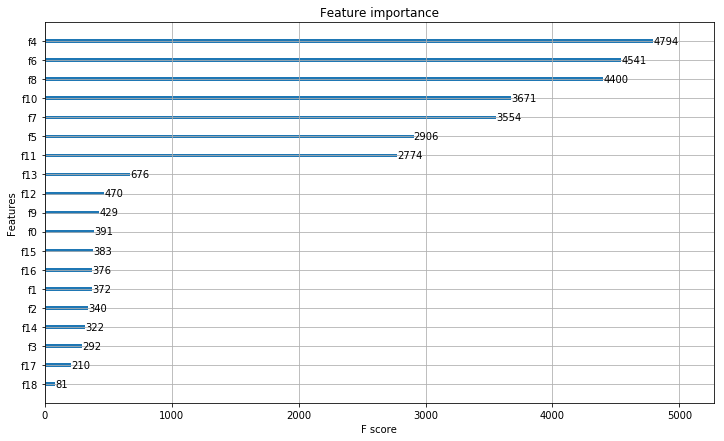

In [200]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

In [174]:
from catboost import CatBoostRegressor

In [112]:
#SET DE DATOS CON POCAS COLUMAS

duration = train_set["duration"]
tys = train_set["timeInSystem"]
deliveryDelay = train_set["Delivery_Delay"]
ttac = train_set["Total_Taxable_Amount_(converted)"]
ocd = train_set["Opportunity_Created_Date_delta"]
ttrf = train_set["Total TRF"]
trfm = train_set["TRF mean"]
opowtarget = train_set["Opportunity_Owner_mean_target"]
regtarget = train_set["Region_mean_target"]
asps = train_set["ASP sum"]


duration1 = test_set["duration"]
tys1 = test_set["timeInSystem"]
deliveryDelay1 = test_set["Delivery_Delay"]
ttac1 = test_set["Total_Taxable_Amount_(converted)"]
ocd1 = test_set["Opportunity_Created_Date_delta"]
ttrf1 = test_set["Total TRF"]
trfm1 = test_set["TRF mean"]
opowtarget1 = test_set["Opportunity_Owner_target"]
asps1 = test_set["ASP sum"]

y = train_set["Target"]


X = pd.DataFrame(duration)
X = X.join(tys)

X = X.join(ttrf)
X = X.join(trfm)
X = X.join(deliveryDelay)
X = X.join(ttac)
X = X.join(ocd)
X = X.join(hb)
#X = X.join(asps)
#X = X.join(opowtarget)


toTest = pd.DataFrame(duration1)
toTest = toTest.join(tys1)
toTest = toTest.join(ttrf1)
toTest = toTest.join(trfm1)
toTest = toTest.join(deliveryDelay1)
toTest = toTest.join(ttac1)
toTest = toTest.join(ocd1)
toTest = toTest.join(hb1)
#toTest = toTest.join(asps1)
#toTest = toTest.join(opowtarget1)

Xs, ys = X.iloc[:,:-1],X.iloc[:,-1]

X_train = X.iloc[:8421]
X_test = X.iloc[8421:]

y_train = y.iloc[:8421]
y_test = y.iloc[8421:]

In [115]:
hp = (98, 5, 8, 2)

rf_model = RandomForestRegressor(n_estimators= hp[0], max_depth = 15, min_samples_split= hp[1], min_samples_leaf= hp[2], max_features=hp[3])
rf_model.fit(X_train, y_train)
preds1 = rf_model.predict(X_test)
print("LOG LOSS:", log_loss(y_test, preds1))


LOG LOSS: 0.3552493404061355


In [18]:
import lightgbm as lgb
import re

In [53]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
toTest = toTest.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))



lgb_train = lgb.Dataset(X, y)

params = {
    'objective': 'regression',
    'metric': 'binary_logloss',
    'max_depth': 25,
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'num_leaves': 15
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200)

preds = gbm.predict(toTest, num_iteration=gbm.best_iteration)
#rmse = log_loss(y_test, preds)
#print("RMSE: %f" % (rmse))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 9791, number of used features: 7
[LightGBM] [Info] Start training from score 0.518027


In [26]:
aogrouped = train_set.groupby(["Account_Owner"]).agg({"Territory":"count"})
oogrouped = train_set.groupby(["Opportunity_Owner"]).agg({"Territory":"count"}).reset_index()
oogrouped.columns = ["Opportunity_Owner","Total ops"]


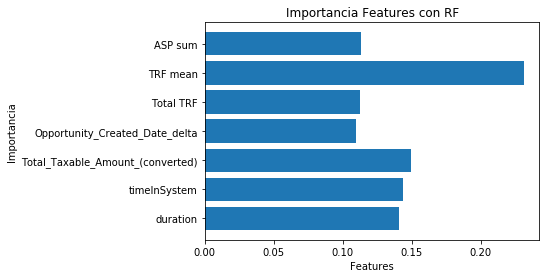

In [223]:
plt.barh(X.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [29]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
Region         5 non-null object
Region_mean    5 non-null float64
dtypes: float64(1), object(1)
memory usage: 160.0+ bytes


In [46]:
test_set.shape

(2551, 51)